In [1]:
# magic command for automatic reload of python modules without needing to restart the notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import math as m
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
import utils as utl
import scipy as sc
from collections import OrderedDict
# importing NN library
import torch as tr
import torch.nn as nn
# importing torch distributions and transformations 
import torch.distributions as trd
import torch.distributions.transforms as trt
from models import ConditionalModel, QuantileRegressionModel
from sklearn import preprocessing

In [3]:
#Reading data
df_trn = pd.read_csv('Predictive_Expenses_DATA/train.csv')
df_tst = pd.read_csv('Predictive_Expenses_DATA/test.csv')

# Reading macroeconomic indicators (inflation and unemployment rates)
df_macro=pd.read_csv('Predictive_Expenses_DATA/macroeconomic_indicators.csv')
df_macro=df_macro.drop(columns=['Unnamed: 0'])

# Merging tables
df_trn = df_trn.merge(df_macro,on=['year','month'])
df_tst = df_tst.merge(df_macro,on=['year','month'])

# Preprocess the data
df_trn = utl.preProcess(df_trn)
df_tst = utl.preProcess(df_tst)

# Keeping only positive portion of the data
df_trn = df_trn.loc[df_trn['expense']>1]


In [4]:
# Further splittling the training dataset into training and validation
# first, shuffling training dataset before splitting (sample with fraction =1 shuffles all the rows)
np.random.seed(0)
df_trn=df_trn.sample(frac=1)
n_trn = int(len(df_trn)*0.75)
# then, splitting
df_vld=df_trn.iloc[n_trn:]
df_trn=df_trn.iloc[:n_trn]

print(f' Train Data Size: {len(df_trn)}, Validation Data Size: {len(df_vld)} Test Data Size: {len(df_tst)}')

 Train Data Size: 538290, Validation Data Size: 179431 Test Data Size: 185469


In [5]:
# Specifying the target and covariates for regression
target = 'log_expense'
covariates_categorical=['marital', 'occupation']
covariates_numeric=['age', 'education', 'familysize', 'log_income']+['inflation','unemployment']
print(f'\033[1m Categorical Covariates: \033[0m {covariates_categorical}')
print(f'\033[1m Numerical Covariates: \033[0m {covariates_numeric}')

 Categorical Covariates:  ['marital', 'occupation']
 Numerical Covariates:  ['age', 'education', 'familysize', 'log_income', 'inflation', 'unemployment']


In [6]:
# Additional data transforms (standarizing Numeric, Hot-encoding categorical)
# Standardizing Numerical covariates
standard_transforms={}
for var in covariates_numeric+[target]:
    # estimate loc and scale w.r.t to training dataset
    standardize = preprocessing.StandardScaler().fit(df_trn[var].to_numpy().reshape(-1,1))
    df_trn[var]=standardize.transform(df_trn[var].to_numpy().reshape(-1,1))
    # also standardize the validation and test datasets
    df_vld[var]=standardize.transform(df_vld[var].to_numpy().reshape(-1,1))
    if var in df_tst:
        df_tst[var]=standardize.transform(df_tst[var].to_numpy().reshape(-1,1))
    standard_transforms[var]=standardize
    
# Hot encoding the categorical variables for all datasets 
df_trn_categorical, new_covariates_categorical=utl.hotEncodeData(df_trn,covariates_categorical)
df_vld_categorical,_=utl.hotEncodeData(df_vld,covariates_categorical)
df_tst_categorical,_=utl.hotEncodeData(df_tst,covariates_categorical)

# Joing the categorical tables into the original tables
df_trn = pd.concat([df_trn,df_trn_categorical],ignore_index=False,axis=1)
df_vld = pd.concat([df_vld,df_vld_categorical],ignore_index=False,axis=1)
df_tst = pd.concat([df_tst,df_tst_categorical],ignore_index=False,axis=1)
# freeing up memory
del df_trn_categorical, df_vld_categorical, df_tst_categorical

In [7]:
# collecting all covariate names
covariates=new_covariates_categorical+covariates_numeric
print(f'\033[1m All Covariates: \033[0m {covariates}')

 All Covariates:  ['marital0', 'marital1', 'marital2', 'marital3', 'occupation0', 'occupation1', 'occupation2', 'occupation3', 'occupation4', 'occupation5', 'occupation6', 'occupation7', 'occupation8', 'occupation9', 'occupation10', 'occupation11', 'occupation12', 'occupation13', 'occupation14', 'occupation15', 'occupation16', 'occupation17', 'age', 'education', 'familysize', 'log_income', 'inflation', 'unemployment']


In [8]:
# Finally setting up the expense conditional distribution
target_transform=trt.ComposeTransform([trt.AffineTransform(standard_transforms['log_expense'].mean_[0],
                                              standard_transforms['log_expense'].scale_[0]),
                                              trt.ExpTransform()]) 

def expense_conditional(X_mat):
    with tr.no_grad():
        mu,log_sig=exp_model.forward(X_mat)
    # First, defining the base distribution
    base_dist=trd.Normal(loc=mu.view(-1,1),scale=tr.exp(log_sig.view(-1,1)))        
    # Then, defining the forward transformation on the log_expense variable
    
    # obtaining the conditional distribution of expense in original units ($)
    expense_dist=trd.TransformedDistribution(base_distribution=base_dist,
                                             transforms=target_transform)
    return expense_dist

In [18]:
# Instantiating the DNN based conditional density model for the target i.e. p(y|X)
input_dim = len(covariates)
layers = []#[input_dim, input_dim, input_dim]
filename='ConditionalGaussian_MLE_loss_linear'
filename_path='saved_models/'+filename
# instantiating the model
exp_model=ConditionalModel(input_dim,layers)
# loading the model
exp_model.load_state_dict(tr.load(filename_path))

<All keys matched successfully>

In [19]:
# Evaluating the model on the validation dataset 
row_ids = df_vld.index.to_list()
X_valid,y_valid, w_valid = utl.getBatch(df_vld, 
                       row_ids,
                       covariates,
                       'log_expense')
X_valid,y_valid, w_valid  = map(tr.FloatTensor,(X_valid,y_valid, w_valid)) 
expense_dist = expense_conditional(X_valid)
# getting the quantiles
q=[0.025, 0.5, 0.975]
Quantiles=expense_dist.icdf(tr.FloatTensor(q)).numpy()
y_valid=target_transform(y_valid)

 PinBall Loss:  671576.875


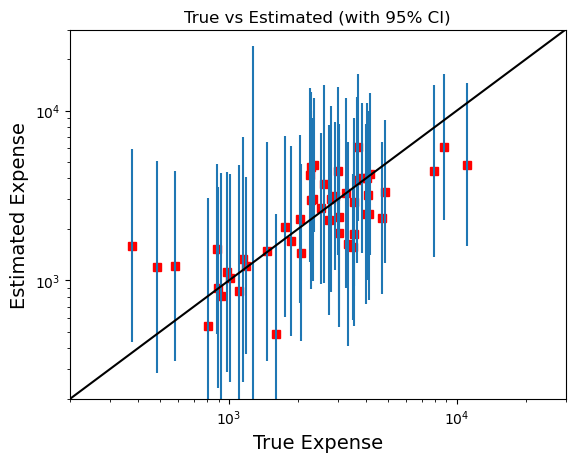

In [20]:
# plotting a few random samples of true Expense vs. the estimated with 90% CI
np.random.seed(0)
ax_limits=[200,30000]
utl.plotQuantiles(y_valid,Quantiles,50, axis_labels={'x':'True Expense', 'y':'Estimated Expense'})
plt.plot(np.array(ax_limits),np.array(ax_limits),'k-')
plt.xlim(ax_limits)
plt.ylim(ax_limits)
print(f'\033[1m PinBall Loss: \033[0m {utl.pinballLoss(Quantiles, q, y_valid, w_valid)}')

In [9]:
# Instantiating the DNN based Quantile Regression Model
input_dim = len(covariates)
layers = [input_dim, input_dim, input_dim]
q = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
filename='QuantileRegressionModel_Macro'
filename_path='saved_models/'+filename
# instantiating the model
exp_model=QuantileRegressionModel(input_dim,layers,q)
# loading the model
exp_model.load_state_dict(tr.load(filename_path))

<All keys matched successfully>

In [10]:
# Evaluating the model on the validation dataset 
row_ids = df_vld.index.to_list()
X_valid,y_valid, w_valid = utl.getBatch(df_vld, 
                       row_ids,
                       covariates,
                       target)
X_valid,y_valid, w_valid  = map(tr.FloatTensor,(X_valid,y_valid, w_valid)) 
with tr.no_grad():
    Quantiles=exp_model.forward(X_valid)
Quantiles=target_transform(Quantiles).numpy()
y_valid=target_transform(y_valid)
Quantiles=Quantiles[:,[1,4,7]]
q=[q[1],q[4],q[7]]

 PinBall Loss:  694827.75


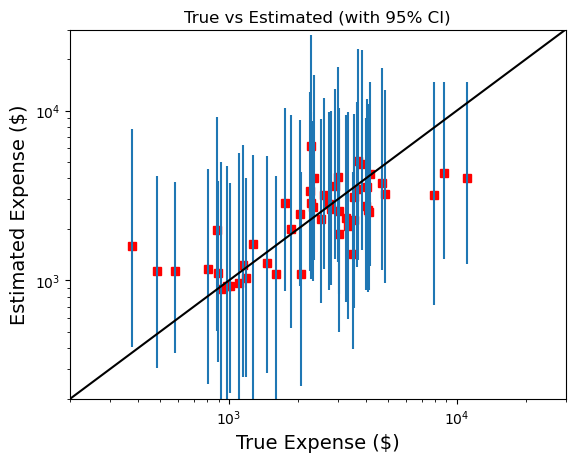

In [11]:
# plotting a few random samples of true Expense vs. the estimated with 90% CI
np.random.seed(0)
ax_limits=[200,30000]
utl.plotQuantiles(y_valid,Quantiles,50, axis_labels={'x':'True Expense ($)', 'y':'Estimated Expense ($)'})
plt.plot(np.array(ax_limits),np.array(ax_limits),'k-')
plt.xlim(ax_limits)
plt.ylim(ax_limits)
print(f'\033[1m PinBall Loss: \033[0m {utl.pinballLoss(Quantiles, q, y_valid, w_valid)}')